In [ ]:
from google.colab import files
uploaded=files.upload()

Saving test_table.csv to test_table.csv
Saving user_table.csv to user_table.csv


# Questions:

You are asked to:

Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

Explain why that might be happening. Are the localized translations really worse?

If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

# Answer:

1. We didn’t collect enough data.
2. Some bias has been introduced in the experiment so that test/control people are not really random.
3. We didn't run enough days for test.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import tree

from scipy.stats import ttest_ind


Load data and preprocess

In [ ]:
test=pd.read_csv('test_table.csv')
test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [ ]:
user=pd.read_csv('user_table.csv')
user.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [ ]:
# check if user_id in both tables are unique or not
print(len(user['user_id'].unique()))
print(len(test['user_id'].unique()))
#yes both are unique but there are more user id in test table, so we need to be careful when merge this two tables

452867
453321


In [ ]:
#merge to one
test=pd.merge(left=test,right=user,how='left',on='user_id')
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


Explorary data analysis

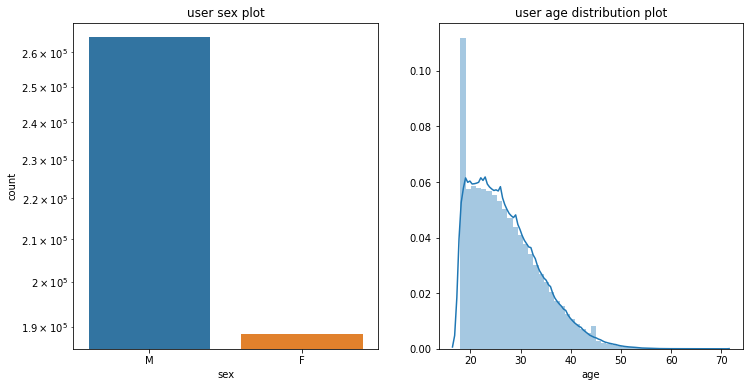

In [ ]:
fig,ax=plt.subplots(figsize=(12,6),nrows=1,ncols=2)
sns.countplot(x=test['sex'],data=test,ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title('user sex plot')
sns.distplot(test['age'],ax=ax[1])
ax[1].set_title('user age distribution plot')
plt.show()

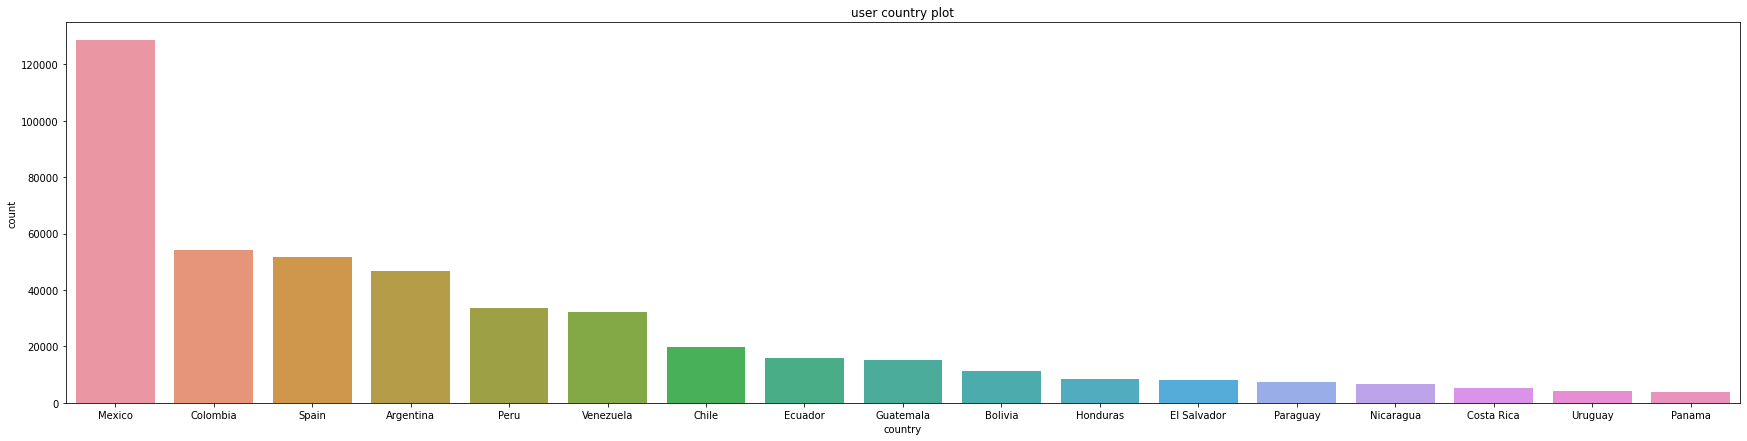

In [ ]:
fig,ax=plt.subplots(figsize=(30,7))
sns.countplot(x=test['country'],data=test,order = test['country'].value_counts().index)
ax.set_title('user country plot')
plt.show()

From user information, we can find the sample users are mostly around 15 to 30, mainly are male. Users mainly are from Mexico, Colombia, Spain, ARGENTINA country.

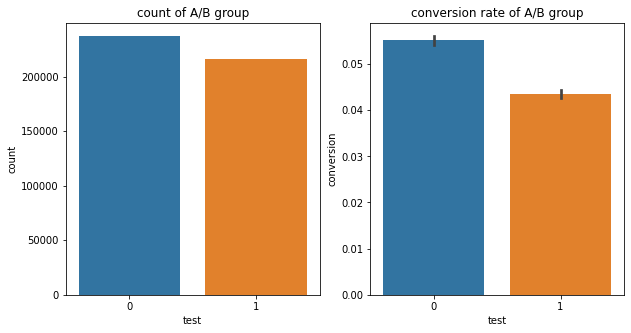

In [ ]:
# current test result: show negative
fig,ax=plt.subplots(figsize=(10,5),nrows=1,ncols=2)
sns.countplot(x=test['test'],data=test,ax=ax[0])
ax[0].set_title('count of A/B group')
sns.barplot(x=test['test'],y=test['conversion'],data=test,ax=ax[1])
ax[1].set_title('conversion rate of A/B group')
plt.show()

In [ ]:
#remove people from Spain. ALthough there is no change for them, but Spanish is already their local language, it's hard and biased to catagorize them to either groups.
test_remove_Spain=test.loc[test['country']!='Spain']

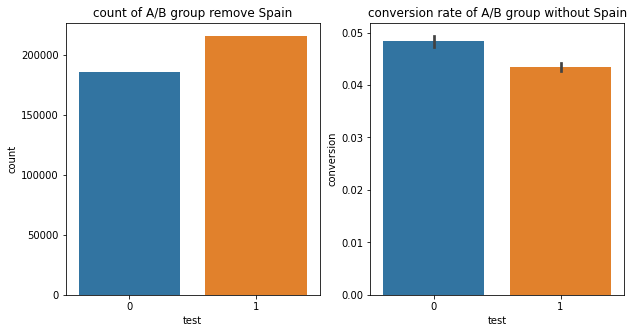

In [ ]:
fig,ax=plt.subplots(figsize=(10,5),nrows=1,ncols=2)
sns.countplot(x=test_remove_Spain['test'],data=test_remove_Spain,ax=ax[0])
ax[0].set_title('count of A/B group remove Spain')
sns.barplot(x=test_remove_Spain['test'],y=test_remove_Spain['conversion'],data=test_remove_Spain,ax=ax[1])
ax[1].set_title('conversion rate of A/B group without Spain')
plt.show()
#it still shows negative

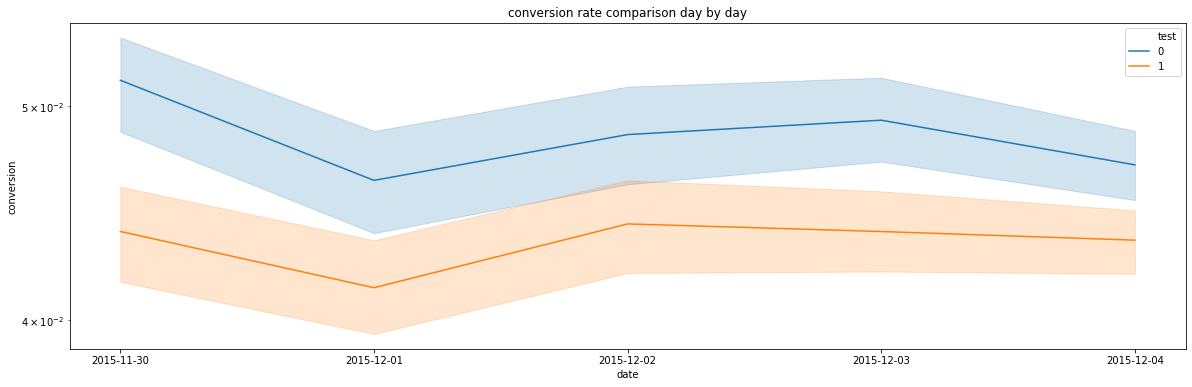

In [ ]:
#then let's check for conversion rate day by day
fig,ax=plt.subplots(figsize=(20,6))
sns.lineplot(x=test_remove_Spain['date'],y=test_remove_Spain['conversion'],hue=test_remove_Spain['test'],data=test_remove_Spain)
ax.set_yscale('log')
ax.set_title('conversion rate comparison day by day')
plt.show()

In [ ]:
# the above graph shows the conversion rate of test is consistently lower than control group, but it just run for 5 days
# We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better.
# then let's build decision tree model to check whether sample is random enough
test_remove_Spain_dummy=pd.get_dummies(test_remove_Spain)
test_remove_Spain_dummy=test_remove_Spain_dummy.dropna()
test_remove_Spain_dummy.head()

,user_id,conversion,test,age,date_2015-11-30,date_2015-12-01,date_2015-12-02,date_2015-12-03,date_2015-12-04,source_Ads,source_Direct,source_SEO,device_Mobile,device_Web,browser_language_EN,browser_language_ES,browser_language_Other,ads_channel_Bing,ads_channel_Facebook,ads_channel_Google,ads_channel_Other,ads_channel_Yahoo,browser_Android_App,browser_Chrome,browser_FireFox,browser_IE,browser_Iphone_App,browser_Opera,browser_Safari,sex_F,sex_M,country_Argentina,country_Bolivia,country_Chile,country_Colombia,country_Costa Rica,country_Ecuador,country_El Salvador,country_Guatemala,country_Honduras,country_Mexico,country_Nicaragua,country_Panama,country_Paraguay,country_Peru,country_Uruguay,country_Venezuela
1,497851,0,1,21.0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,290051,0,1,22.0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,548435,0,1,19.0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,540675,0,1,22.0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,863394,0,0,35.0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


[Text(167.4, 181.2, 'X[22] <= 0.5\ngini = 0.497\nsamples = 320868\nvalue = [148314, 172554]'),
 Text(83.7, 108.72, 'X[36] <= 0.5\ngini = 0.5\nsamples = 283347\nvalue = [140804, 142543]'),
 Text(41.85, 36.23999999999998, 'gini = 0.5\nsamples = 280069\nvalue = [140487, 139582]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.175\nsamples = 3278\nvalue = [317, 2961]'),
 Text(251.10000000000002, 108.72, 'X[19] <= 0.5\ngini = 0.32\nsamples = 37521\nvalue = [7510, 30011]'),
 Text(209.25, 36.23999999999998, 'gini = 0.319\nsamples = 34185\nvalue = [6796, 27389]'),
 Text(292.95, 36.23999999999998, 'gini = 0.336\nsamples = 3336\nvalue = [714, 2622]')]

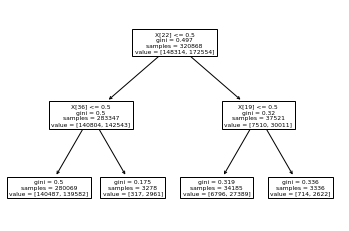

In [ ]:
#use decision tree to check
#If the tree splits, it means that for given values of that variable you are more likely to end up in test or control. But this should be impossible! Therefore, if the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well).
x=pd.concat([test_remove_Spain_dummy.iloc[:,9:],test_remove_Spain_dummy.iloc[:,3]],axis=1)
y=test_remove_Spain_dummy.iloc[:,2]
x_train, x_test, y_train, y_test=train_test_split(x,y,random_state=42,test_size=0.2)
clf=tree.DecisionTreeClassifier(max_depth=2)
clf=clf.fit(x_train,y_train)
tree.plot_tree(clf)

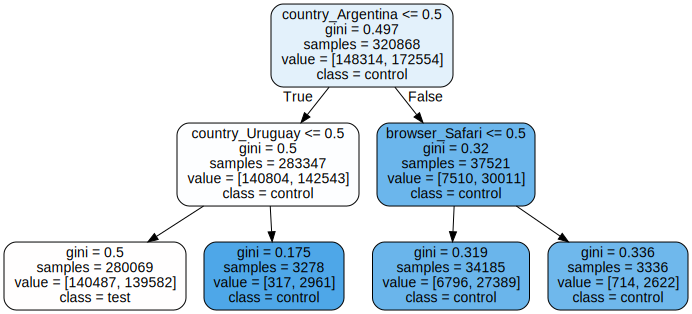

In [ ]:
y_train_name=y_train.map({0:'control',1:'test'})
y_train.unique()
y_train_name.unique()
dot_data = tree.export_graphviz(clf, out_file=None, 
                       feature_names=list(x_train),
                       class_names=y_train_name.unique(),
                      filled=True, rounded=True)  
graph = graphviz.Source(dot_data)  
graph 

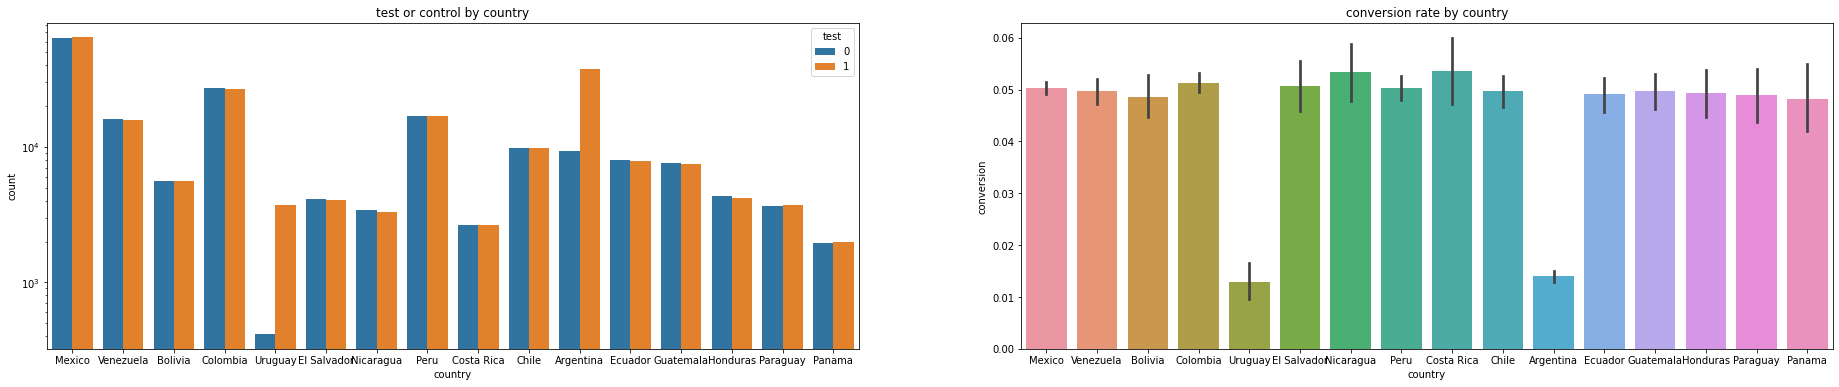

In [ ]:
#from the above graph, country and browser are two factors maynot random, let's do more exploration
fig,ax=plt.subplots(figsize=(32,6),nrows=1,ncols=2)
sns.countplot(x=test_remove_Spain['country'],hue=test_remove_Spain['test'],data=test_remove_Spain,ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title('test or control by country')
sns.barplot(x=test_remove_Spain['country'],y=test_remove_Spain['conversion'],data=test_remove_Spain,ax=ax[1])
ax[1].set_title('conversion rate by country')
plt.show()

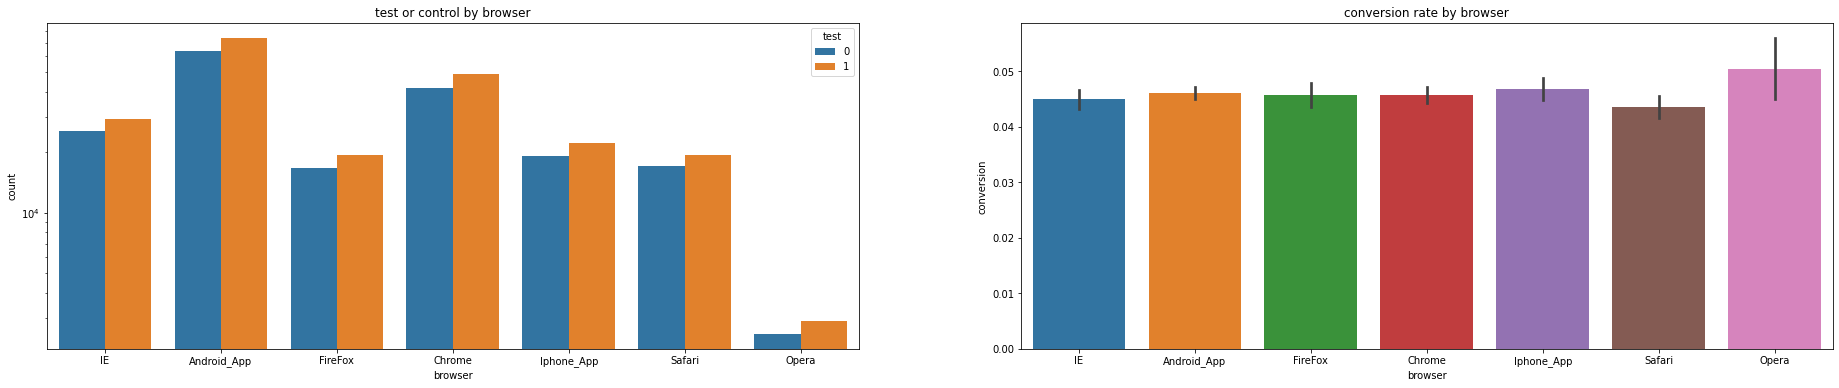

In [ ]:
fig,ax=plt.subplots(figsize=(32,6),nrows=1,ncols=2)
sns.countplot(x=test_remove_Spain['browser'],hue=test_remove_Spain['test'],data=test_remove_Spain,ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title('test or control by browser')
sns.barplot(x=test_remove_Spain['browser'],y=test_remove_Spain['conversion'],data=test_remove_Spain,ax=ax[1])
ax[1].set_title('conversion rate by browser')
plt.show()

In [ ]:
#from these two group graphs, we can see country is not random enough, let's check the conversion rate after removing country as factor
test_remove_Spain_group_country=test_remove_Spain.groupby(['country','test']).mean().reset_index()
test_remove_Spain_group_country.head()

,country,test,user_id,conversion,age
0,Argentina,0,496688.319367,0.015071,27.124198
1,Argentina,1,499662.469888,0.013725,27.132782
2,Bolivia,0,496550.053333,0.049369,27.196937
3,Bolivia,1,499866.009508,0.047901,26.997309
4,Chile,0,505092.208566,0.048107,27.188268


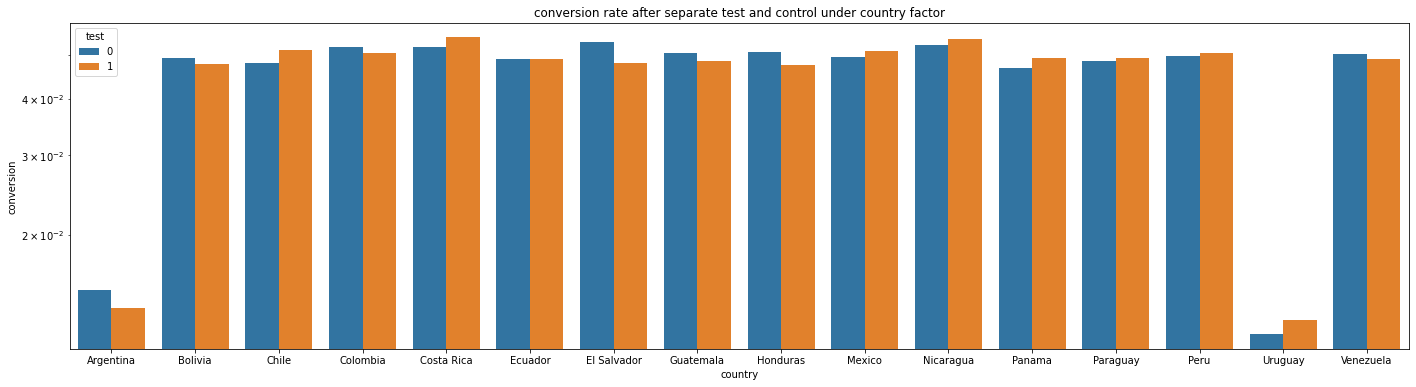

In [ ]:
fig,ax=plt.subplots(figsize=(24,6))
sns.barplot(x=test_remove_Spain_group_country['country'],y=test_remove_Spain_group_country['conversion'],hue=test_remove_Spain_group_country['test'],data=test_remove_Spain_group_country)
ax.set_yscale('log')
ax.set_title('conversion rate after separate test and control under country factor')
plt.show()

In [ ]:
#from the above graph, we can see the conversion rate of test group and control group is similar, at least the translation doesn't make the conversion worse
#use p-value to verify our discovery
countries = [name for name in test_remove_Spain_group_country['country'].unique() if name is not np.nan]

for country in countries:
    test_val = test_remove_Spain[(test_remove_Spain['country'] == country) & (test_remove_Spain['test'] == 1)]['conversion'].values
    cont_val = test_remove_Spain[(test_remove_Spain['country'] == country) & (test_remove_Spain['test'] == 0)]['conversion'].values
    
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue 

    print(country, p_val)

Argentina 0.3351465468746866
Bolivia 0.7188852468451075
Chile 0.30284764308444695
Colombia 0.4237190741314115
Costa Rica 0.6878763537073986
Ecuador 0.9615116906006622
El Salvador 0.2481266743266678
Guatemala 0.5721072081912069
Honduras 0.4714628565257586
Mexico 0.16554372211039645
Nicaragua 0.7804003858904794
Panama 0.7053268372725889
Paraguay 0.8836965034962364
Peru 0.7719529885153548
Uruguay 0.8797639736514224
Venezuela 0.5737015234387255
